## Exploring the Data Provided by Quartix

# Data Format
* Categorised Data
    * 95 Examples, 16 Crashes, 79 Not Crashes
* Uncategorised Data
    * 406 Examples, unlabelled incidents
* Unlinked Data
    * Reduced amount of data on 6071 incidents

In [1]:
from extract_data import *

# Import the code using pickle

cat_data = load_list('pickle_data', 'cat_data')
uncat_data = load_list('pickle_data', 'uncat_data')
unlinked_data = load_list('pickle_data', 'unlinked_data')

C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


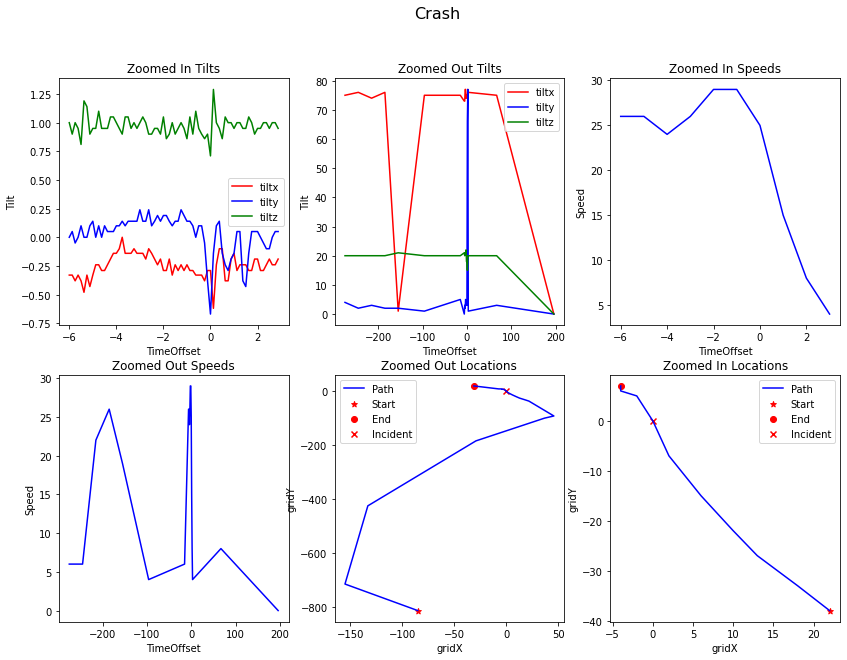

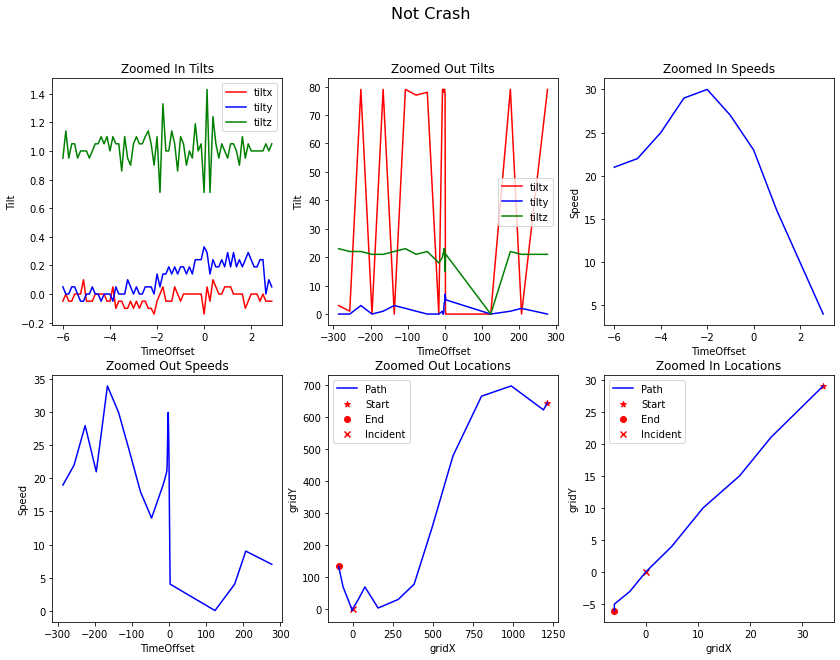

In [2]:
# Get example incident and plot

crash = cat_data[5]
not_crash = cat_data[30]
plot_example(crash, 'Crash')
plot_example(not_crash, 'Not Crash')

## Accelerometer Data Analysis
Plotting many tilt against time graphs to get a gist for the data.

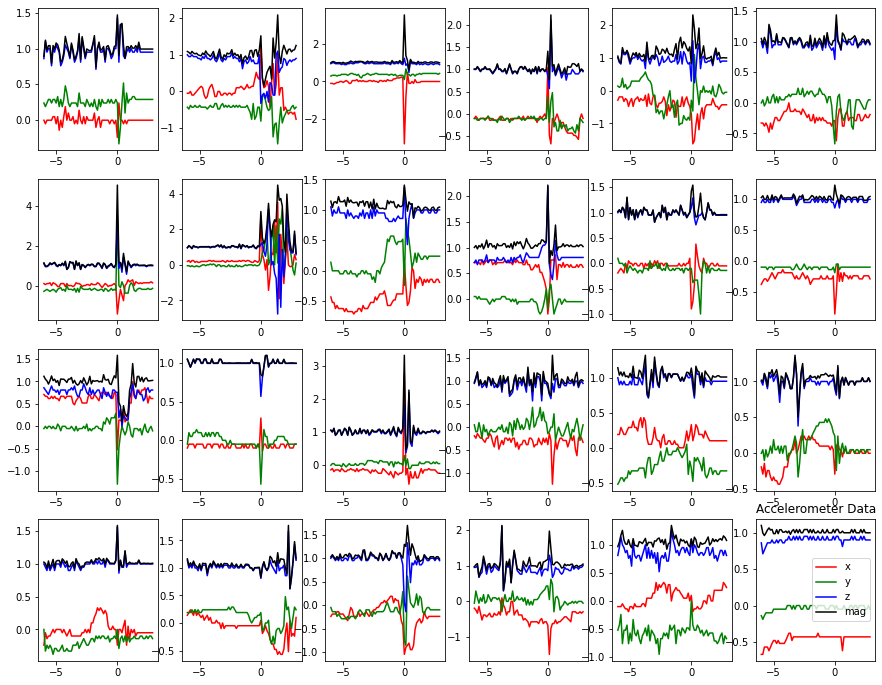

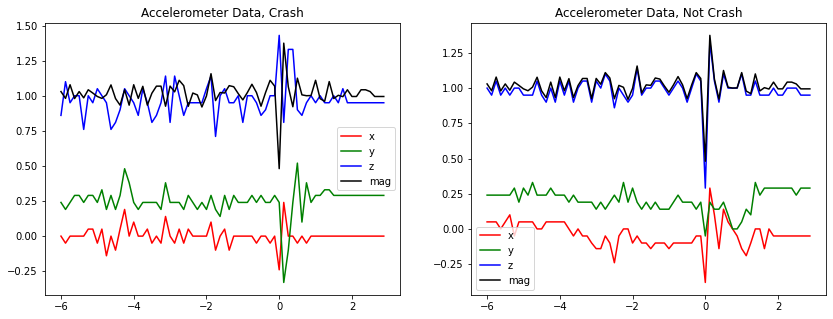

In [3]:
import random as rand

# Get the tilts for cat_data and plot an example crash and exameple not crash
crash_no = 0
no_crash_no = 40

all_tilts = get_tilt_timeseries(cat_data)
crash_tilts = all_tilts[crash_no,:,:]
no_crash_tilts = all_tilts[no_crash_no,:,:]
tilt_mags = get_mags(all_tilts)

colours = ['r','g','b']
labels = ['x','y','z']

timeoffset = np.linspace(-6,2.875,72)

fig=plt.figure(figsize=(15,12)), 
for k in range(24):
    plt.subplot(4,6,k+1)
    for i in range(3):
        plt.plot(timeoffset, all_tilts[k,:,i], c=colours[i], label = labels[i])
    plt.plot(timeoffset, tilt_mags[k], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data') 
plt.show()

fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(timeoffset, crash_tilts[:,i], c=colours[i], label = labels[i])
plt.plot(timeoffset, tilt_mags[no_crash_no], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data, Crash') 
plt.subplot(1,2,2)
for i in range(3):
    plt.plot(timeoffset, no_crash_tilts[:,i], c=colours[i], label = labels[i])
plt.plot(timeoffset, tilt_mags[no_crash_no], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data, Not Crash') 
plt.show()

## PCA on Tilt Magnitudes

60 components explain 0.9798222562490099 percent of the data


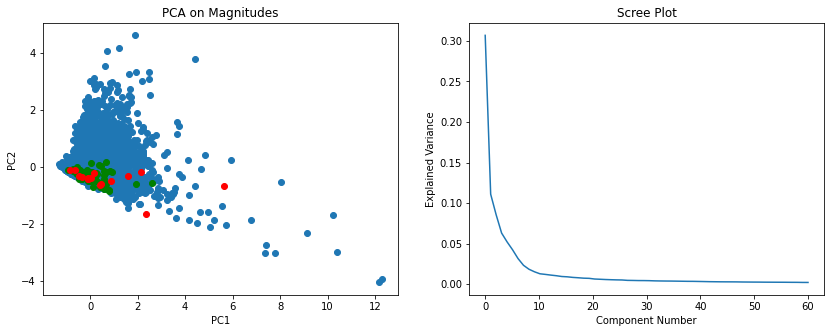

In [45]:
from sklearn.decomposition import PCA

# Get unlinked tilts
all_tilts = get_tilt_timeseries(unlinked_data)
#all_tilts = calibrate_tilts(all_tilts)
all_mags = get_mags(all_tilts)

# Get labelled tilts
test_tilts = get_tilt_timeseries(cat_data)
#test_tilts = calibrate_tilts(test_tilts)
test_mags = get_mags(test_tilts)
labels = np.array(get_labels(cat_data))
crash_ref = labels.nonzero()
nocrash_refs = (-1*(labels-1)).nonzero()

# Init PCA
n_components = 60
pca = PCA(n_components=n_components)

pca_mags = pca.fit_transform(all_mags)
pca_test_mags = pca.transform(test_mags)

# Plotting
fig=plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.scatter(pca_mags[:,0], pca_mags[:,1])
plt.scatter(pca_test_mags[nocrash_refs, 0], pca_test_mags[nocrash_refs, 1], color='green')
plt.scatter(pca_test_mags[crash_ref, 0], pca_test_mags[crash_ref, 1], color='red')
plt.xlabel('PC1'), plt.ylabel('PC2'), plt.title('PCA on Magnitudes')
plt.subplot(1,2,2)
plt.plot(np.linspace(0,n_components,n_components), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance'), plt.xlabel('Component Number'), plt.title('Scree Plot')

print(len(pca.explained_variance_ratio_),'components explain', sum(pca.explained_variance_ratio_), 'percent of the data')


## PCA on Individual Directions
This shows how there are outliers (the small clusters away from the main cluster along PC1).

These outliers are due to the accelerometers being oriented incorrectly or perhaps calibrated wrong.

By uncommenting the calibrate tilts line (make sure you run the next cell first) you can see the PCA once the outliers are hopefully removed.

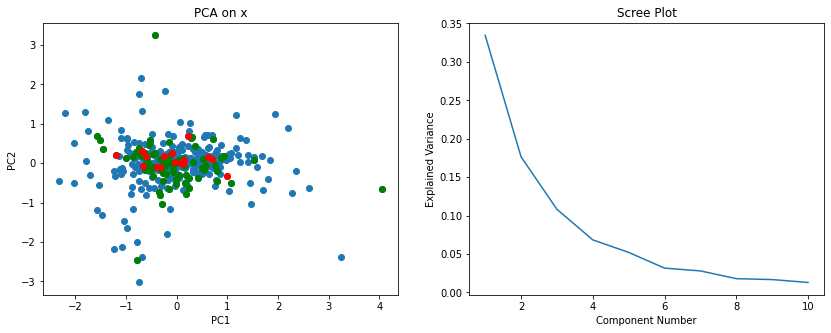

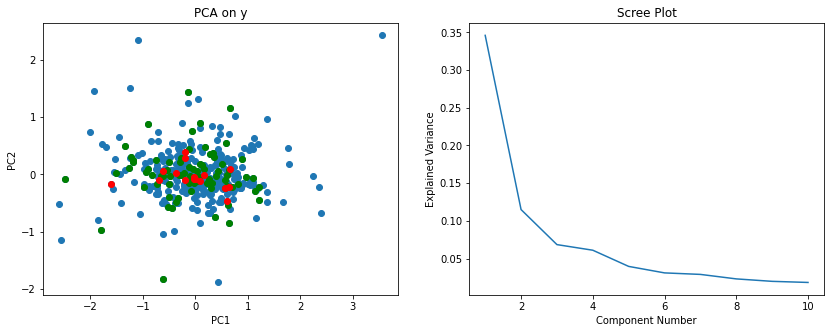

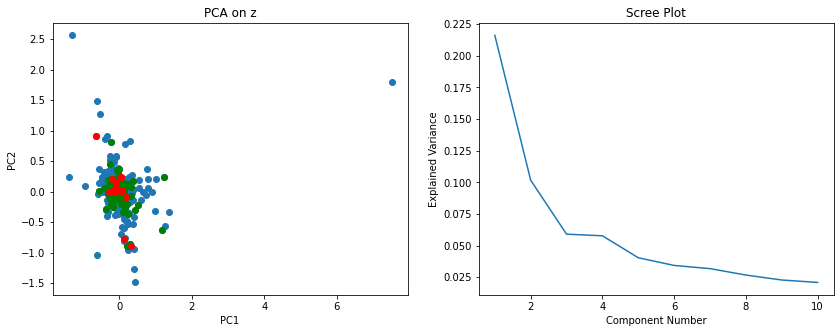

In [41]:
all_tilts = get_tilt_timeseries(uncat_data)
#all_tilts = calibrate_tilts(all_tilts)
x_tilts = all_tilts[:,:,0]
y_tilts = all_tilts[:,:,1]
z_tilts = all_tilts[:,:,2]
tilts = [x_tilts, y_tilts, z_tilts]

test_tilts = get_tilt_timeseries(cat_data)
#test_tilts = calibrate_tilts(all_tilts)
test_tilt_x = test_tilts[:,:,0]
test_tilt_y = test_tilts[:,:,1]
test_tilt_z = test_tilts[:,:,2]
test_tilts = [test_tilt_x, test_tilt_y, test_tilt_z]

dirs = ['x','y','z']

for i in range(3):
    # Init PCA
    n_components = 10
    pca = PCA(n_components=n_components)
    pca_tilts = pca.fit_transform(tilts[i])
    pca_test_tilts = pca.transform(test_tilts[i])

    # Plotting PC1/2 and scree plots
    fig=plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
    plt.scatter(pca_tilts[:,0], pca_tilts[:,1])
    plt.xlabel('PC1'), plt.ylabel('PC2'), plt.title('PCA on '+  dirs[i])
    plt.scatter(pca_test_tilts[nocrash_refs, 0], pca_test_tilts[nocrash_refs, 1], color='green')
    plt.scatter(pca_test_tilts[crash_ref, 0], pca_test_tilts[crash_ref, 1], color='red')
    plt.subplot(1,2,2)
    plt.plot(np.linspace(1,n_components,n_components), pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance'), plt.xlabel('Component Number'), plt.title('Scree Plot')

## Calibrating Accelerometer Data
Calculating the average acceleration for the first 4 seconds and then removing that from the whole time series to remove the effect of gravity.

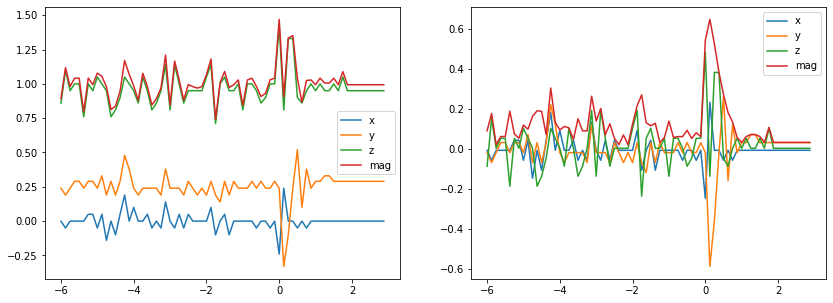

In [38]:
# Function to hopefully remove the effects of gravity and centre the data around 0
def calibrate_tilts(data):
    cali_data = np.empty(data.shape)
    for i in range(len(data)):
        # Calculate the average over the first 4 seconds (average shouldn't be affected by the crash)
        x_av = np.sum(data[i,:32,0])/len(data[i,:32,0])
        y_av = np.sum(data[i,:32,1])/len(data[i,:32,1])
        z_av = np.sum(data[i,:32,2])/len(data[i,:32,2])
        # Remove that average to centre the data
        cali_data[i,:,0] = data[i,:,0] - x_av
        cali_data[i,:,1] = data[i,:,1] - y_av
        cali_data[i,:,2] = data[i,:,2] - z_av
    return cali_data

# Get tilts and calibrate
tilts = get_tilt_timeseries(cat_data)
cali_tilts = calibrate_tilts(tilts)
tilt_mags = get_mags(tilts)
cali_mags = get_mags(cali_tilts)

incident_no = 0

# Plotting
fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.plot(timeoffset, tilts[incident_no,:,0], label='x')
plt.plot(timeoffset, tilts[incident_no,:,1], label='y')
plt.plot(timeoffset, tilts[incident_no,:,2], label='z')
plt.plot(timeoffset, tilt_mags[incident_no,:], label='mag')
plt.legend()
plt.subplot(1,2,2)
plt.plot(timeoffset, cali_tilts[incident_no,:,0], label='x')
plt.plot(timeoffset, cali_tilts[incident_no,:,1], label='y')
plt.plot(timeoffset, cali_tilts[incident_no,:,2], label='z')
plt.plot(timeoffset, cali_mags[incident_no,:], label='mag')
plt.legend()
plt.show()


## Scaling the Data to Reduce the Effect of Outliers
Experimenting with different scalers to see how they affect the data.

Perhaps one can be used to centre the ztilts around 0 rather than 1 or -1 due to gravity.

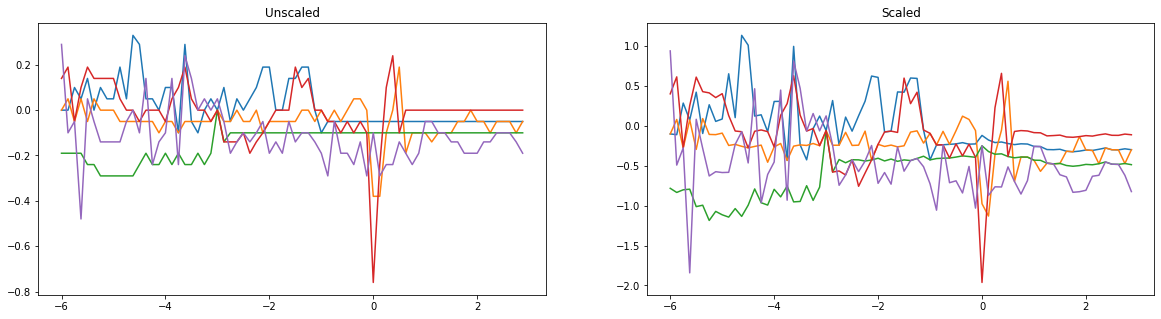

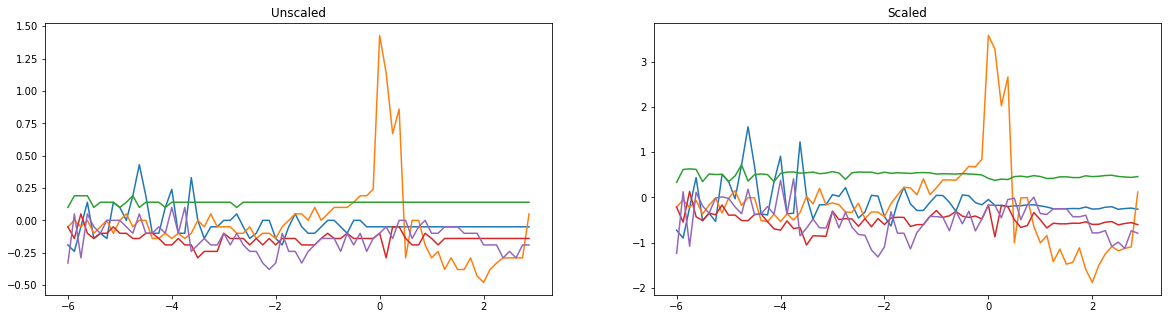

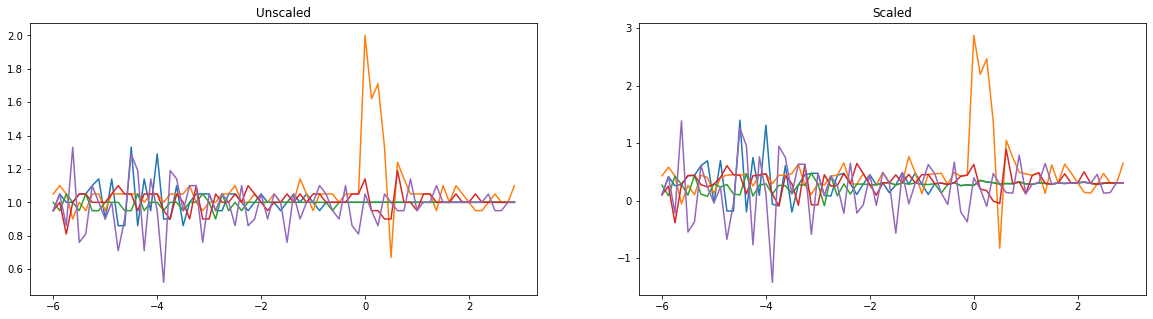

In [27]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Get the Data
train_tilts = get_tilt_timeseries(uncat_data)
scaled_tilts = train_tilts

# Init scalers
r_scaler_x = StandardScaler()
r_scaler_y = StandardScaler()
r_scaler_z = StandardScaler()

# Fit the scaler for each axis
scaled_tilts[:,:,0] = r_scaler_x.fit_transform(X = scaled_tilts[:,:,0])
scaled_tilts[:,:,1] = r_scaler_y.fit_transform(X = scaled_tilts[:,:,1])
scaled_tilts[:,:,2] = r_scaler_z.fit_transform(X = scaled_tilts[:,:,2])

# Plot tilts to see effect of scaling
train_tilts = get_tilt_timeseries(uncat_data)
for a in range(3):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    for i in range(5):
        plt.plot(timeoffset, train_tilts[i,:,a], label='Unscaled')
    plt.title('Unscaled')
    plt.subplot(1,2,2)
    for i in range(5):
        plt.plot(timeoffset, scaled_tilts[i,:,a], label='Scaled')
    plt.title('Scaled')
    plt.show()


## Finite Response Filtering ???

## Clustering Using TimeSeriesKMeans and Acceleration Magnitude
Since the z-direction contains the most mis-oriented accelerometers and is affected by gravity I tried removing that axis and calculating the magnitude of acceleration only in the horizontal plane.
 - this is now redundant since the tilt data is being calibrated (z is being included)

PCA is used to visualise the data in 2D.

The inertia is used with an elbow plot to find the optimal number of clusters.

KMeans is used with DTW on the magnitudes in the horizontal plane.

There are still outliers as some mis-oriented boxes will have some axes swapped (x and z or y and z) therefore making the magnitude dominated by one of the directions.
- again, redundant due to calibration

Takes a long time to run when fitting on the unlinked data.

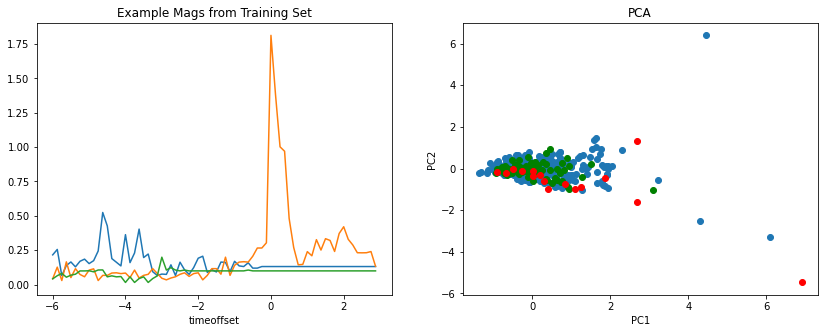

Explained Variances: [0.39656654 0.13540514 0.09107737 0.05136446]


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 95 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Accuracy: 0.5894736842105263
[[48  0  7 24]
 [ 4  1  8  3]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Inertia(n= 5 ): 0.3806000763349948


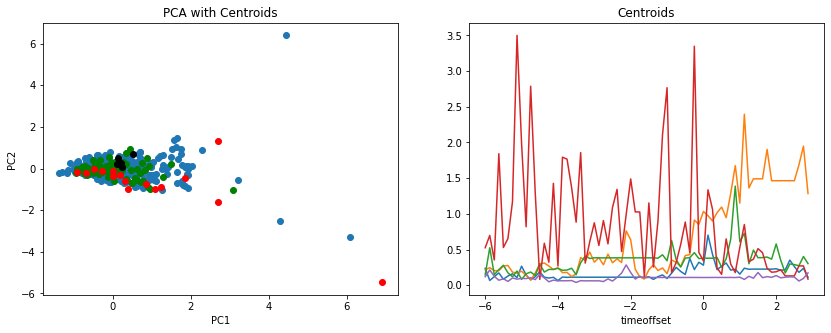

In [47]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape
from metrics import *
from sklearn.metrics import confusion_matrix

# Attempt at clustering magnitude in the horizontal plane

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_tilts(train_tilts) # Using new calibration
#train_tilts = train_tilts[:,:,:2] # remove z axis
#train_tilts[:,:,0] = r_scaler_x.fit_transform(train_tilts[:,:,0])
#train_tilts[:,:,1] = r_scaler_y.fit_transform(train_tilts[:,:,1])
train_mags = get_mags(train_tilts)

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_tilts(test_tilts) # Using new calibration
#test_tilts = test_tilts[:,:,:2] # remove z axis
#test_tilts[:,:,0] = r_scaler_x.transform(test_tilts[:,:,0])
#test_tilts[:,:,1] = r_scaler_y.transform(test_tilts[:,:,1])
test_mags = get_mags(test_tilts)
y = get_labels(cat_data)

# Compute PCA for visualisations
pca = PCA(n_components=4)
pca.fit(train_mags)
train_mags_pca = pca.transform(train_mags)
test_mags_pca = pca.transform(test_mags)

fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
# PLot 3 examples from training set
for i in range(3):
    plt.plot(timeoffset, train_mags[i,:])
plt.title('Example Mags from Training Set'), plt.xlabel('timeoffset')
# Plot PCA on training/test set
plt.subplot(1,2,2)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.title('PCA'), plt.xlabel('PC1'), plt.ylabel('PC2')
plt.show()
print('Explained Variances:', pca.explained_variance_ratio_)

'''
# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = TimeSeriesKMeans(n, metric='dtw', dtw_inertia=True)
    km.fit(train_mags)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()
'''

# Run KMeans with DTW
n_clusters = 5
km = TimeSeriesKMeans(n_clusters, metric='dtw', dtw_inertia=True)
#km = KShape(n_clusters)
km.fit(train_mags)
y_pred = km.predict(test_mags)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
centroids = np.reshape(centroids, (n_clusters,72))
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Transfrom centroids into PCA space
centroids_pca = pca.transform(centroids)

# Plot PC1/2
fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.scatter(centroids[:,0], centroids[:,1], c='black')
plt.title('PCA with Centroids'), plt.xlabel('PC1'), plt.ylabel('PC2')
# Plot centroid PCs
plt.subplot(1,2,2)
for i in range(n_clusters):
    plt.plot(timeoffset, centroids[i,:])
plt.title('Centroids'), plt.xlabel('timeoffset')
plt.show()